<a href="https://colab.research.google.com/github/algoplutus1708/stock-market-predictor-lstm/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project code**

In [97]:
#Installation for Google colab in particular
# Run this in a new cell
!pip install d2l --no-deps
!pip install "numpy>=1.21.0" jupyter matplotlib pandas requests

In [98]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from d2l import torch as d2l

from sklearn.preprocessing import MinMaxScaler
import math, time
from math import sqrt
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import statistics as st
import scipy as sc

# **Part 1: Data exploration**

In the data cleaning stage, we removed missing data and re-organised the dates and columns of the dataset. Most of it is to make the data easier to handle later on.

In [99]:
#Loading in data
url = 'FB.csv'
meta = pd.read_csv(url)
meta = meta.dropna(how='any',axis=0) #If there is missing data
meta['Date'].apply(pd.to_datetime) #For ease of adjusting dates later on
len(meta.index)

2479

In [100]:
meta = meta[['Close'] + [col for col in meta if col not in ['Adj Close', 'Close', 'Date']] + ['Adj Close', 'Date']]

In [101]:
#Sorting dates
meta = meta.sort_values('Date')
meta.head()

,Close,Open,High,Low,Volume,Adj Close,Date
0,38.230000,42.049999,45.000000,38.000000,573576400,38.230000,2012-05-18
1,34.029999,36.529999,36.660000,33.000000,168192700,34.029999,2012-05-21
2,31.000000,32.610001,33.590000,30.940001,101786600,31.000000,2012-05-22
3,32.000000,31.370001,32.500000,31.360001,73600000,32.000000,2012-05-23
4,33.029999,32.950001,33.209999,31.770000,50237200,33.029999,2012-05-24


Once we completed the data cleaning, we carried out some data exploration to understand the properties of the dataset. Some of the few properties we can look at are maximum, minimum values, mean, variance, skewness, and kurtosis.


In [102]:
print(max(meta['Open']))
print(max(meta['High']))
print(max(meta['Low']))
print(max(meta['Close']))
print(max(meta['Volume']))





381.679993
384.329987
378.809998
382.179993
573576400


In [103]:
print(min(meta['Open']))
print(min(meta['High']))
print(min(meta['Low']))
print(min(meta['Close']))
print(min(meta['Volume']))

18.08
18.27
17.549999
17.73
5913100


In [104]:
print(st.mean(meta['Open']))
print(st.mean(meta['High']))
print(st.mean(meta['Low']))
print(st.mean(meta['Close']))
print(st.mean(meta['Volume']))

147.08882611375554
148.8585840669625
145.30103273658733
147.12594593787819
30907570.431625657


In [105]:
print(np.var(meta['Open']))
print(np.var(meta['High']))
print(np.var(meta['Low']))
print(np.var(meta['Close']))
print(np.var(meta['Volume']))

8040.690742871802
8240.127416742982
7851.262452651933
8047.793203955047
756223607983277.9


In [106]:
print(sc.stats.skew(meta['Open']))
print(sc.stats.skew(meta['High']))
print(sc.stats.skew(meta['Low']))
print(sc.stats.skew(meta['Close']))
print(sc.stats.skew(meta['Volume']))

0.5953227954986721
0.5972091084786186
0.5936537955005652
0.5943793164504073
5.845654354927807


In [107]:
print(sc.stats.kurtosis(meta['Open']))
print(sc.stats.kurtosis(meta['High']))
print(sc.stats.kurtosis(meta['Low']))
print(sc.stats.kurtosis(meta['Close']))
print(sc.stats.kurtosis(meta['Volume']))

-0.3361579700994586
-0.34495996695628817
-0.32882869769866563
-0.3366185022972008
77.20988537231108


Since it is common for stock prediction projects to use closing prices to make predictions, we decided to plot the closing prices of Meta's stock to see if there were any interesting patterns.

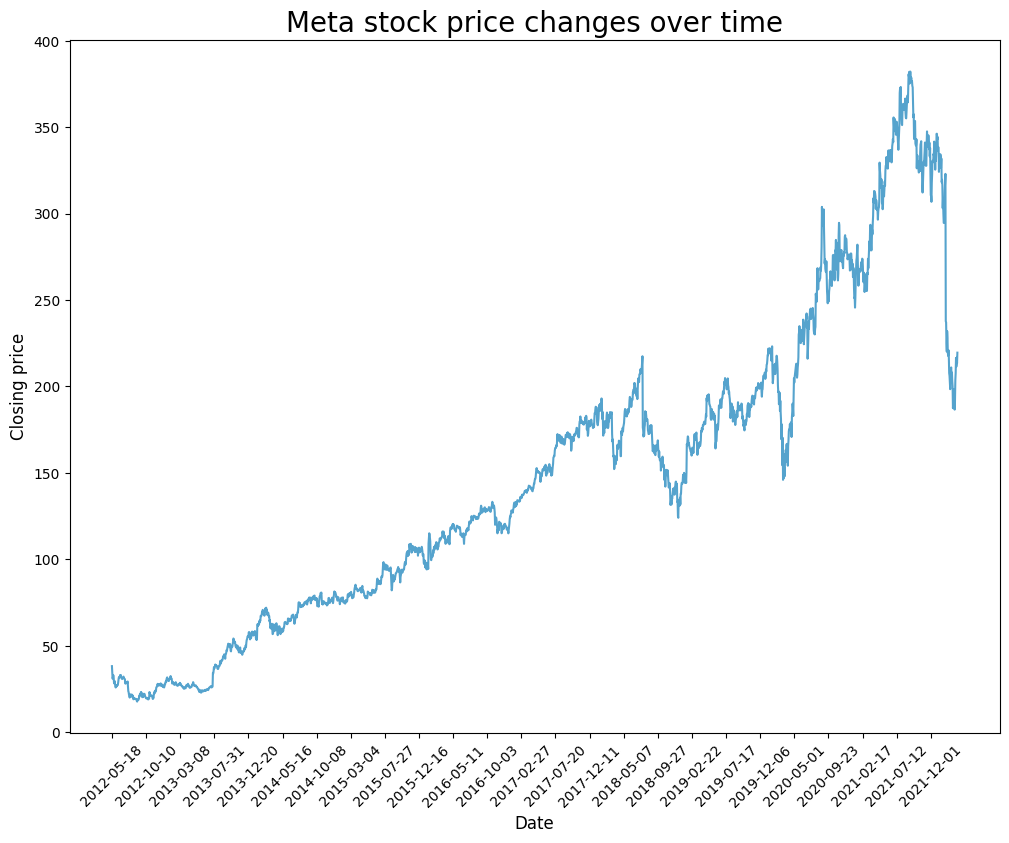

In [108]:
plt.figure(figsize = (12,9))
plt.plot(meta.Date, meta.Close)
plt.xticks(range(0,meta.shape[0],100),meta['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Closing price',fontsize=12)
plt.title('Meta stock price changes over time',fontsize=20)
plt.show()

In [109]:
# short_MA = meta.rolling(window=15).mean()
# long_MA = meta.rolling(window=80).mean()
# Assuming you have columns like 'Close', 'Open', 'High', 'Low'
short_MA = meta['Close'].rolling(window=15).mean()
long_MA = meta['Close'].rolling(window=80).mean()

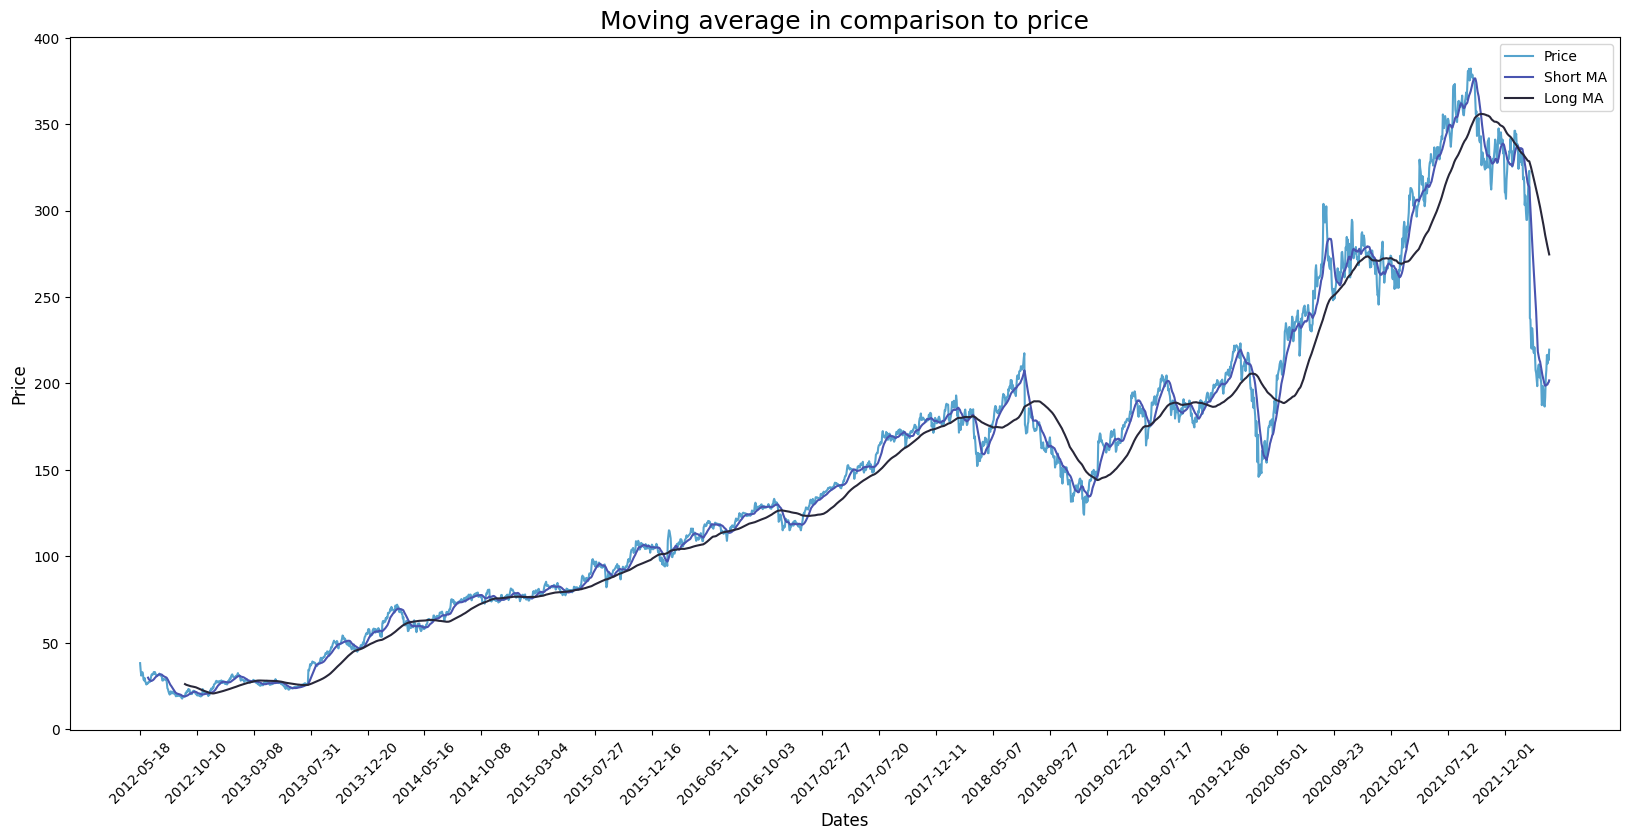

In [110]:
# plt.figure(figsize=(20,9))

# plt.xlabel('Dates',fontsize=12)
# plt.ylabel('Price',fontsize=12)
# plt.title('Moving average in comparison to price',fontsize=18)

# plt.plot(meta.Date,meta.Close,label='Price')
# plt.plot(meta.Date,short_MA.Close, label='Short MA')
# plt.plot(meta.Date,long_MA.Close,label='Long MA')

# plt.xticks(range(0,meta.shape[0],100),meta.Date.loc[::100],rotation=45)

# plt.legend()
# plt.show()

plt.figure(figsize=(20,9))

plt.xlabel('Dates',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.title('Moving average in comparison to price',fontsize=18)

plt.plot(meta.Date, meta.Close, label='Price')
plt.plot(meta.Date, short_MA, label='Short MA')  # Remove .Close
plt.plot(meta.Date, long_MA, label='Long MA')    # Remove .Close

plt.xticks(range(0,meta.shape[0],100),meta.Date.loc[::100],rotation=45)

plt.legend()
plt.show()


Upon plotting the closing prices along with short and long moving averages, we found that Meta's stock prices have been fluctuating across the entire time frame of 2012 to 2021. Therefore, we'll be using the dataset across the entire time frame rather than subsetting the data.

# **Part 2: Models and data preprocessing**

In the model building process, we've only included the code for the best parameters after experimenting. The base parameters we started with are listed in the report.

Due to the randomness of weight initialisation along with the stochastic nature of our optimization algorithm, rerunning the code will likely give different results each time.

**Section 1: Multilayer perceptron model (Model 1)**

In the first model, we start with a simple structure. This model has four inputs (open, high, low and volume), one hidden layer, and one output. The aim of this model is to predict the closing price given this information.

In [111]:
#Preparing inputs
from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(meta, test_size = 0.2, random_state = 21)

X_train_array = training_set.iloc[:,1:-2].values
y_train_array = training_set.iloc[:,0:1].values

X_test_array = test_set.iloc[:,1:-2].values
y_test_array = test_set.iloc[:,0:1].values

In [112]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_array = scaler.fit_transform(X_train_array)
X_test_array = scaler.fit_transform(X_test_array)
y_train_array = scaler.fit_transform(y_train_array)
y_test_array = scaler.fit_transform(y_test_array)

In [113]:
training = torch.tensor(X_train_array, dtype=torch.float32)
test = torch.tensor(X_test_array, dtype=torch.float32)

In [114]:
trainlabels = torch.tensor(y_train_array, dtype=torch.float32)
testlabels = torch.tensor(y_test_array, dtype=torch.float32)

In [115]:
#MLP model set up with activation functions
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden)
        nn.init.kaiming_uniform_(self.hidden.weight) #Initialising weights
        self.activation = nn.ReLU()
        self.out = nn.Linear(num_hidden, num_output)

    def forward(self, X):
        X = self.hidden(X)
        X = self.activation(X)
        X = self.out(X)
        return X

In [116]:
#Model specifics
num_input, num_output, num_hidden = 4, 1, 4
model_1 = MLP(num_input, num_output, num_hidden)

In [117]:
loss = nn.MSELoss()

Here, we train the model. The results of the training for all models are in the model performance section.

In [118]:
#Training the model
train_hist_mlp1 = np.zeros(100)
net = model_1
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)
for epoch in range(100):
    optimizer.zero_grad()
    y_predmlp1 = net(training)
    l = loss(y_predmlp1, trainlabels)
    train_hist_mlp1[epoch] = l.item()
    print("Epoch ", epoch, "MSE: ", l)
    l.backward()
    optimizer.step()

Epoch  0 MSE:  tensor(1.1765, grad_fn=<MseLossBackward0>)
Epoch  1 MSE:  tensor(1.1469, grad_fn=<MseLossBackward0>)
Epoch  2 MSE:  tensor(0.7682, grad_fn=<MseLossBackward0>)
Epoch  3 MSE:  tensor(0.0615, grad_fn=<MseLossBackward0>)
Epoch  4 MSE:  tensor(0.0594, grad_fn=<MseLossBackward0>)
Epoch  5 MSE:  tensor(0.0575, grad_fn=<MseLossBackward0>)
Epoch  6 MSE:  tensor(0.0556, grad_fn=<MseLossBackward0>)
Epoch  7 MSE:  tensor(0.0536, grad_fn=<MseLossBackward0>)
Epoch  8 MSE:  tensor(0.0513, grad_fn=<MseLossBackward0>)
Epoch  9 MSE:  tensor(0.0488, grad_fn=<MseLossBackward0>)
Epoch  10 MSE:  tensor(0.0460, grad_fn=<MseLossBackward0>)
Epoch  11 MSE:  tensor(0.0429, grad_fn=<MseLossBackward0>)
Epoch  12 MSE:  tensor(0.0394, grad_fn=<MseLossBackward0>)
Epoch  13 MSE:  tensor(0.0357, grad_fn=<MseLossBackward0>)
Epoch  14 MSE:  tensor(0.0318, grad_fn=<MseLossBackward0>)
Epoch  15 MSE:  tensor(0.0277, grad_fn=<MseLossBackward0>)
Epoch  16 MSE:  tensor(0.0235, grad_fn=<MseLossBackward0>)
Epoch  

In [119]:
y_pred_test = model_1(test)

In [120]:
y_train_pred_origmlp = scaler.inverse_transform(y_predmlp1.detach().numpy())
y_train_origmlp = scaler.inverse_transform(trainlabels.detach().numpy())

In [121]:
y_test_predmlp = scaler.inverse_transform(y_pred_test.detach().numpy())
y_testmlp = scaler.inverse_transform(testlabels.detach().numpy())

**Section 2: Multilayer perceptron model with the sliding window method (Model 2)**

In this model, we are using the sliding window method as our input. This time, we want to predict the price at time t, given all the prices in 0 to t-1 days. The weight initialisation, loss, and optimiser functions are the same as in model 1. The only differences are that the model will have a different number of inputs, and an additional dropout layer to prevent overfitting.

In [122]:
#Preparing inputs
closing = meta[['Close']]

In [123]:
scaler = MinMaxScaler(feature_range=(0, 1))
closing['Close'] = scaler.fit_transform(closing['Close'].values.reshape(-1,1))

/tmp/ipython-input-3218315939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing['Close'] = scaler.fit_transform(closing['Close'].values.reshape(-1,1))


In [124]:
def split_data(data, timeframe):
    numpydata = data.to_numpy()
    data = []

    for index in range(len(numpydata) - timeframe): #Subtracting timeframe because the last few inputs will have NaN values
        data.append(numpydata[index: index + timeframe])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]
timeframe = 31
x_train, y_train, x_test, y_test = split_data(closing, timeframe)

In [125]:

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train= torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


In [126]:
x_train.shape

torch.Size([1958, 30, 1])

In [127]:
x_train = torch.transpose(x_train, 1, 2)
x_train = x_train.reshape(1958, 30)

In [128]:
x_test.shape

torch.Size([490, 30, 1])

In [129]:
x_test = torch.transpose(x_test, 1, 2)
x_test = x_test.reshape(490, 30)

In [130]:
#MLP model set up with activation functions
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden)
        nn.init.kaiming_uniform_(self.hidden.weight)
        self.activation = nn.ReLU()
        self.out = nn.Linear(num_hidden, num_output)

    def forward(self, X):
        X = self.hidden(X)
        if self.training == True:
          X = dropout_layer(X, dropout = 0.2)
        X = self.activation(X)
        X = self.out(X)
        return X

In [131]:
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  # In this case, all elements are dropped out
  if dropout == 1:
    return torch.zeros_like(X)
    # In this case, all elements are kept
  if dropout == 0:
    return X
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

In [132]:
#Model structure
num_input, num_output, num_hidden = 30, 1, 4
model_1 = MLP(num_input, num_output, num_hidden)

In [133]:
#Training the model
train_hist_mlp2 = np.zeros(100)
net = model_1.train()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)
for epoch in range(100):
    optimizer.zero_grad()
    y_pred = net(x_train)
    l = loss(y_pred, y_train)
    train_hist_mlp2[epoch] = l.item()
    print("Epoch ", epoch, "MSE: ", l)
    l.backward()
    optimizer.step()

Epoch  0 MSE:  tensor(0.1808, grad_fn=<MseLossBackward0>)
Epoch  1 MSE:  tensor(0.0212, grad_fn=<MseLossBackward0>)
Epoch  2 MSE:  tensor(0.0201, grad_fn=<MseLossBackward0>)
Epoch  3 MSE:  tensor(0.0192, grad_fn=<MseLossBackward0>)
Epoch  4 MSE:  tensor(0.0183, grad_fn=<MseLossBackward0>)
Epoch  5 MSE:  tensor(0.0169, grad_fn=<MseLossBackward0>)
Epoch  6 MSE:  tensor(0.0159, grad_fn=<MseLossBackward0>)
Epoch  7 MSE:  tensor(0.0145, grad_fn=<MseLossBackward0>)
Epoch  8 MSE:  tensor(0.0135, grad_fn=<MseLossBackward0>)
Epoch  9 MSE:  tensor(0.0127, grad_fn=<MseLossBackward0>)
Epoch  10 MSE:  tensor(0.0120, grad_fn=<MseLossBackward0>)
Epoch  11 MSE:  tensor(0.0112, grad_fn=<MseLossBackward0>)
Epoch  12 MSE:  tensor(0.0110, grad_fn=<MseLossBackward0>)
Epoch  13 MSE:  tensor(0.0106, grad_fn=<MseLossBackward0>)
Epoch  14 MSE:  tensor(0.0098, grad_fn=<MseLossBackward0>)
Epoch  15 MSE:  tensor(0.0093, grad_fn=<MseLossBackward0>)
Epoch  16 MSE:  tensor(0.0092, grad_fn=<MseLossBackward0>)
Epoch  

In [134]:
y_test_pred = model_1(x_test)

In [135]:
y_train_pred_origmlp2 = scaler.inverse_transform(y_pred.detach().numpy())
y_train_origmlp2 = scaler.inverse_transform(y_train.detach().numpy())

In [136]:
y_test_predmlp2 = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_origmlp2 = scaler.inverse_transform(y_test.detach().numpy())

**Section 3: Recurrent neural network (RNN) model with the sliding window method (Model 3)**

Here, we prepare the data again. This time, we've normalised the data after splitting because normalising the data altogether gives away extra information. Similar to before, this model aims to predict the price on day t given past information from 0 to t-1 days.

In [137]:
closing_price = meta[['Close']]

In [138]:
window_size = 15 #14 input values and 15th value is the target

In [139]:
#Function for normalising and splitting data
scaler = MinMaxScaler(feature_range=(-1, 1))

def split_data(prices, window):
    raw = prices.to_numpy()
    data = []
    plotting = []

    #The last 15 indexes will include null values so we subtract the window size
    for index in range(len(raw) - window):
        plotting.append(raw[index][0])
        data.append(raw[index: index + window])

    plotting = pd.DataFrame(plotting)
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    X_train = data[:train_set_size,:-1,]
    X_train = scaler.fit_transform(X_train.reshape(-1,1))
    X_train = X_train.reshape(train_set_size, window - 1, 1)
    y_train = data[:train_set_size,-1,:]
    y_train = scaler.fit_transform(y_train)

    X_test = data[:test_set_size,:-1,]
    X_test = scaler.fit_transform(X_test.reshape(-1,1))
    X_test = X_test.reshape(test_set_size, window - 1, 1)
    y_test = data[:test_set_size,-1,]
    y_test = scaler.fit_transform(y_test)

    return [X_train, y_train, X_test, y_test, train_set_size, test_set_size]

In [140]:
#Preparing inputs
X_train, y_train, X_test, y_test, train_size, test_size = split_data(closing_price, window_size)

In [141]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [142]:
X_train.shape

torch.Size([1971, 14, 1])

In [143]:
X_test.shape

torch.Size([493, 14, 1])

In [144]:
y_train_rnn.shape

torch.Size([1971, 1])

In [145]:
y_test_rnn.shape

torch.Size([493, 1])

In the vanilla RNN model, we've created a simple one input, one hidden, and one output layer structure. The hidden layer will be constructed using RNN layers as per the code below. An additional element in the forward step is the hidden state.

In [146]:
#RNN model
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, num_outputs):
        super(RNN, self).__init__()
        self.num_hiddens = num_hiddens #Number of neurons in the hidden layer
        self.num_layers = num_layers #Number of hidden layers
        self.rnn = nn.RNN(num_inputs, num_hiddens, num_layers, batch_first = True) #RNN layer includes inputs and hidden states
        self.fc = nn.Linear(num_hiddens, num_outputs) #Output

    def forward(self, X):
        #Initialising hidden state
        h0 = torch.zeros(self.num_layers, X.size(0), self.num_hiddens).requires_grad_()
        out, h_state = self.rnn(X, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

The number of inputs is only 1 because if we look at the shape of our input tensors, each inputs consists of 14 values directly.

In [147]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

We'll use the Adam optimiser for both the RNN and LSTM model to experiment with different optimiser functions.

In [148]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.1
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [149]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)

    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.4397416412830353
Epoch  5 MSE:  0.054245080798864365
Epoch  10 MSE:  0.02631237916648388
Epoch  15 MSE:  0.009558313526213169
Epoch  20 MSE:  0.007187170907855034
Epoch  25 MSE:  0.001999595668166876
Epoch  30 MSE:  0.0018775187199935317
Epoch  35 MSE:  0.001332065206952393
Epoch  40 MSE:  0.0014504630817100406
Epoch  45 MSE:  0.0009578929166309536
Epoch  50 MSE:  0.0008934545912779868
Epoch  55 MSE:  0.0008845533593557775
Epoch  60 MSE:  0.0008520599803887308
Epoch  65 MSE:  0.0008163577294908464
Epoch  70 MSE:  0.0007897076429799199
Epoch  75 MSE:  0.0007887624087743461
Epoch  80 MSE:  0.0007768531213514507
Epoch  85 MSE:  0.0007625057478435338
Epoch  90 MSE:  0.0007523912354372442
Epoch  95 MSE:  0.0007464021327905357


**Section 4: LSTM model with the sliding window method (Model 4)**

Similar to the RNN model, we've created a simple one input, one hidden, and one output layer structure. The hidden layer will be constructed with the LSTM function instead.

In [150]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim #Number of neurons in hidden layer
        self.num_layers = num_layers #Number of hidden layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) #LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) #Output layer

    def forward(self, x):
        #Intialising hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        #Intialising cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h_0.detach(), c_0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [151]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 10, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [152]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.1
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [153]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_lstm = lstm_model(X_train)

    loss = lstm_criterion(y_train_pred_lstm, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

Epoch  0 MSE:  0.33314597606658936
Epoch  5 MSE:  0.05211392045021057
Epoch  10 MSE:  0.01625363528728485
Epoch  15 MSE:  0.004410219378769398
Epoch  20 MSE:  0.0017347867833450437
Epoch  25 MSE:  0.0028778105042874813
Epoch  30 MSE:  0.0024786083959043026
Epoch  35 MSE:  0.0016519461059942842
Epoch  40 MSE:  0.0013733357191085815
Epoch  45 MSE:  0.0009201591019518673
Epoch  50 MSE:  0.0007641254924237728
Epoch  55 MSE:  0.0007110353908501565
Epoch  60 MSE:  0.0006578752654604614
Epoch  65 MSE:  0.0006461875163950026
Epoch  70 MSE:  0.0006520577007904649
Epoch  75 MSE:  0.0006423235754482448
Epoch  80 MSE:  0.0006311635952442884
Epoch  85 MSE:  0.000629880465567112
Epoch  90 MSE:  0.000629825983196497
Epoch  95 MSE:  0.0006267387070693076


# **Part 3: Model performance**

In this section, we've included the training loss plots to assess how well the model trained. To measure the model's performance overall, our main measure is using the root-mean-squared error. Following the RMSE value, we have also plotted the predictions against the actual prices for a visual comparison. In particular, the test RMSE speaks more volumes than the training RMSE because it measures the model's performance on unseen data.

**Section 1: Multilayer perceptron model (Model 1)**

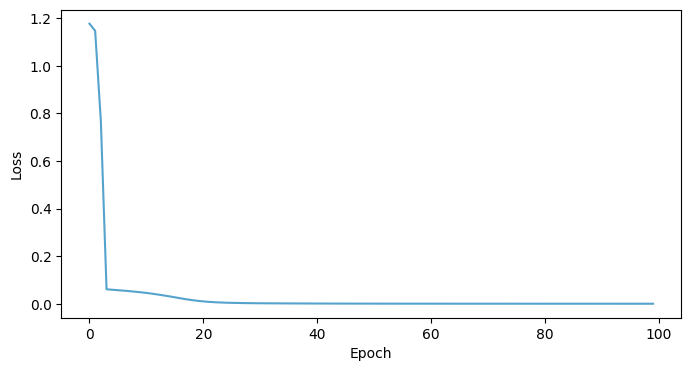

In [154]:
#Training loss for MLP model 1
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_hist_mlp1)

In [155]:
#Training RMSE for MLP model 1
TrainRMSE = sqrt(mean_squared_error(y_train_origmlp, y_train_pred_origmlp))
print(TrainRMSE)

9.386548063366982


In [156]:
#Testing RMSE for MLP model 1
TestRMSE = sqrt(mean_squared_error(y_testmlp, y_test_predmlp))
print(TestRMSE)

10.403190827555326


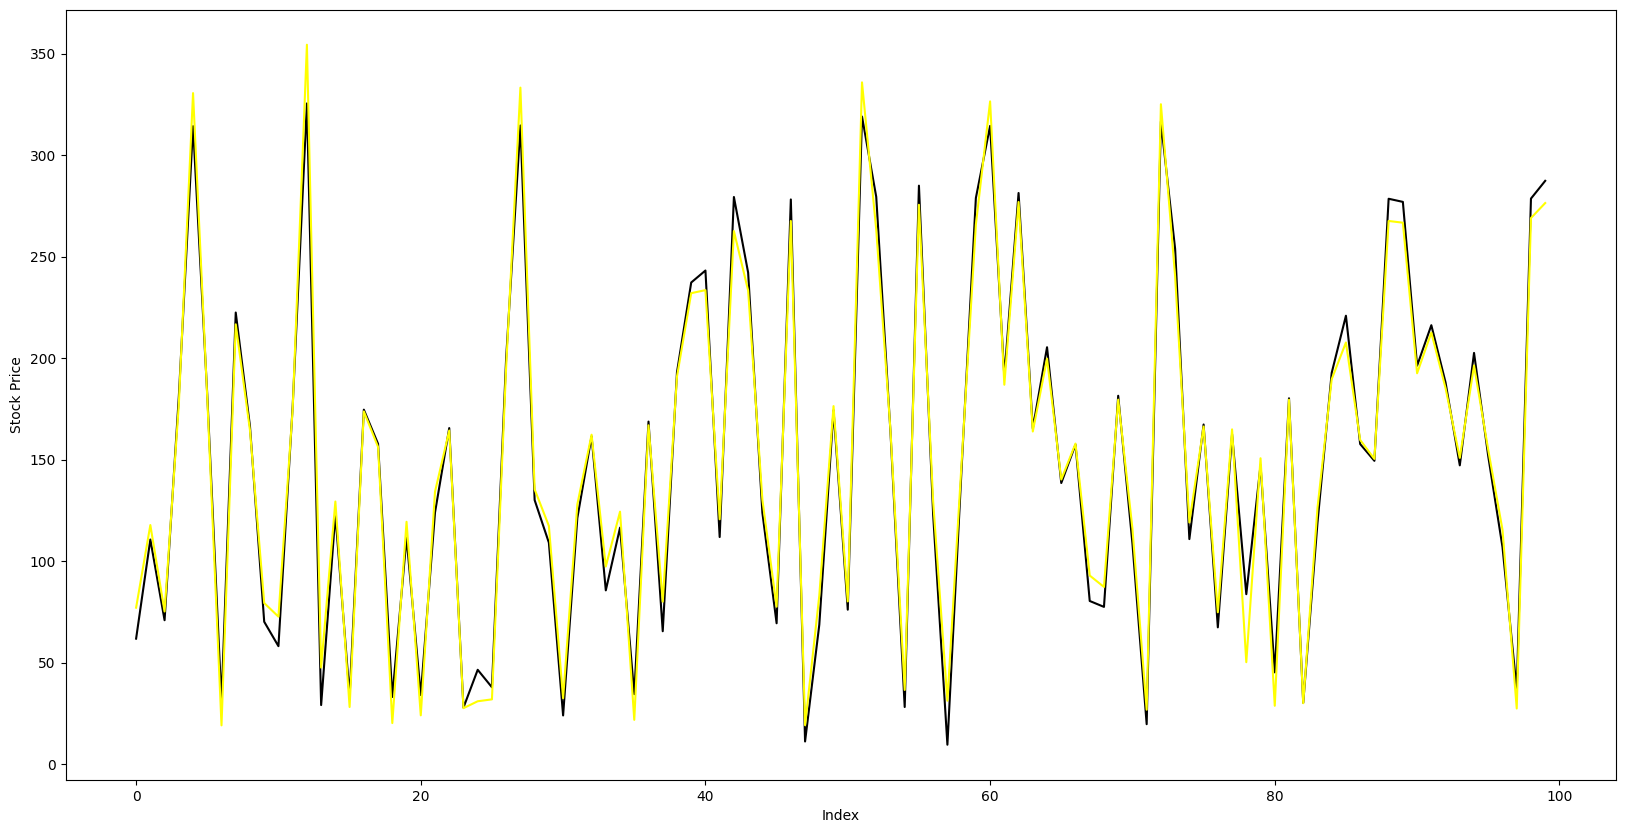

In [157]:
#Actual vs predicted prices for MLP model 1
plt.figure(figsize = (20,10))
plt.plot(y_test_predmlp[0:100], color = 'black')
plt.plot(y_testmlp[0:100], color = 'yellow')
plt.xlabel('Index')
plt.ylabel('Stock Price');

The performance of this model is good. However, we explained that it's not particularly useful in the report. This is because this model takes information from the day itself to predict the closing price. It's only helpful if a trader planned to buy and sell on the same day.

**Section 2: Multilayer perceptron model with the sliding window method (Model 2)**

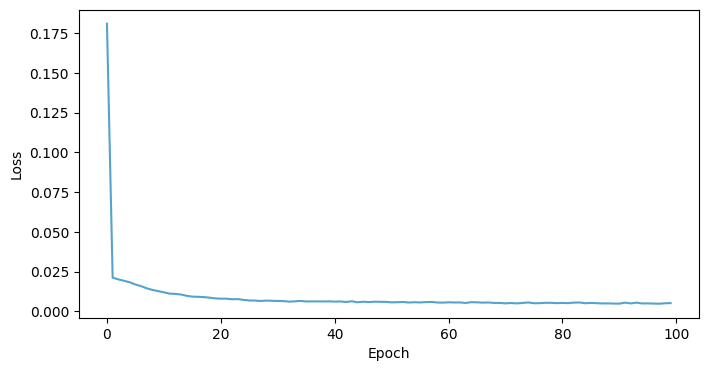

In [158]:
#Training loss for MLP model 2
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_hist_mlp2)

In [159]:
#Training RMSE for MLP model 2
TrainRMSE = sqrt(mean_squared_error(y_train_origmlp2, y_train_pred_origmlp2))
print(TrainRMSE)

26.315865561927417


In [160]:
#Testing RMSE for MLP model 2
TestRMSE = sqrt(mean_squared_error(y_test_origmlp2, y_test_predmlp2))
print(TestRMSE)

131.0712175212392


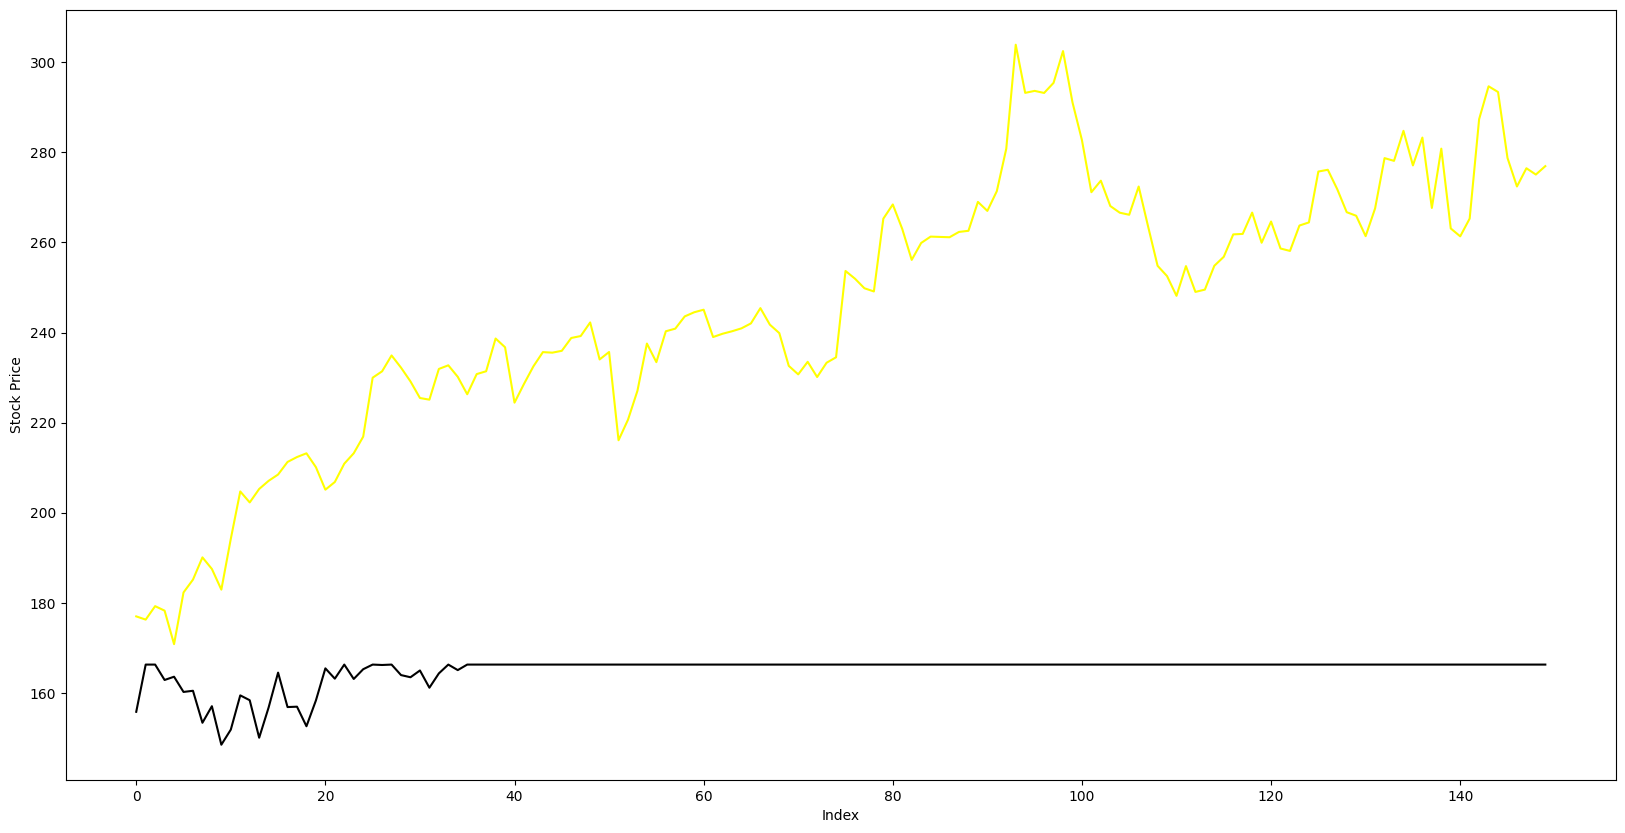

In [161]:
#Actual vs predicted prices for MLP model 2
plt.figure(figsize = (20,10))
plt.plot(y_test_predmlp2[0:150], color = 'black')
plt.plot(y_test_origmlp2[0:150], color = 'yellow')
plt.xlabel('Index')
plt.ylabel('Stock Price');

Based on the RMSE scores and the plots, this model didn't perform particularly well. It identified increasing and decreasing patterns well, but the magnitude of the price drops and increases are exaggerated.

**Section 3: Recurrent neural network (RNN) model with the sliding window method (Model 3)**

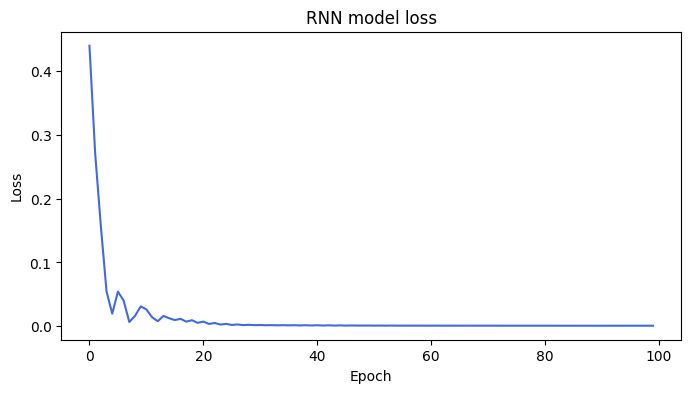

In [162]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
rnn_loss_fig = sns.lineplot(data = train_hist_rnn, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN model loss")
plt.show(rnn_loss_fig);

In [163]:
#RNN model performance on testing data
y_test_pred_rnn = rnn_model(X_test)

In [164]:
#Converting the data back to its original form
rnn_train_pred = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
rnn_train_orig = scaler.inverse_transform(y_train_rnn.detach().numpy())
rnn_test_pred = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
rnn_test_orig = scaler.inverse_transform(y_test_rnn.detach().numpy())

In [165]:
#RNN model RMSE
train_rnn_RMSE = math.sqrt(mean_squared_error(rnn_train_orig[:,0], rnn_train_pred[:,0]))
print('Train RMSE: %.2f' % (train_rnn_RMSE))
test_rnn_RMSE = math.sqrt(mean_squared_error(rnn_test_orig[:,0], rnn_test_pred[:,0]))
print('Test RMSE: %.2f' % (test_rnn_RMSE))

Train RMSE: 0.74
Test RMSE: 1.25


In [166]:
#Preparing predictions for the plot comparisons for RNN model
rnn_train_data = np.append(rnn_train_orig, rnn_train_pred, axis = 1)
rnn_test_data = np.append(rnn_test_orig, rnn_test_pred, axis = 1)

rnn_train_plot = pd.DataFrame(rnn_train_data)
rnn_train_plot.columns = ['Actual', 'Prediction']
rnn_test_plot = pd.DataFrame(rnn_test_data)
rnn_test_plot.columns = ['Actual', ' Prediction']

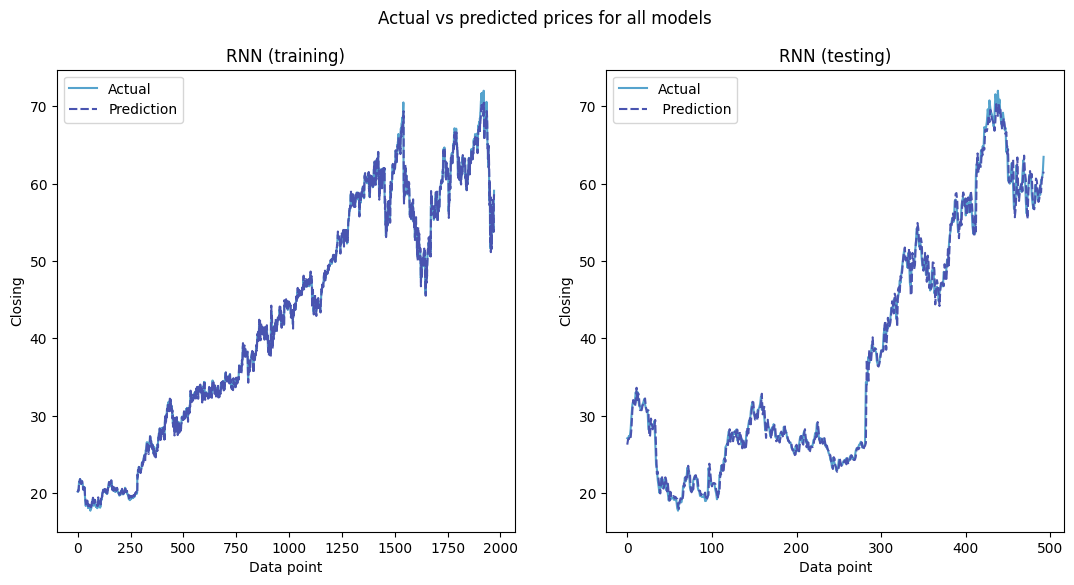

In [167]:
#Predictions vs actual price for the RNN model
sns.set_palette('icefire')

fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
fig.suptitle('Actual vs predicted prices for all models')

rnn_training_plot = sns.lineplot(ax = axes[0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')
rnn_training_plot.set_xlabel('Data point')
rnn_training_plot.set_ylabel('Closing')

rnn_testing_plot = sns.lineplot(ax = axes[1], data = rnn_test_plot)
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')
rnn_testing_plot.set_ylabel('Closing');

From the plot, the RNN seems to do a decent job at predicting prices. As expected, its performance is visibly worse than the LSTM model.

**Section 4: LSTM model with the sliding window method (Model 4)**

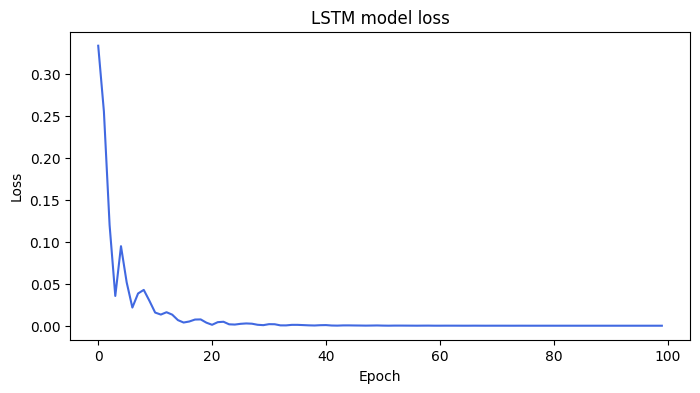

In [168]:
#Training loss for LSTM model
rcParams['figure.figsize'] = 8,4
lstm_loss_fig = sns.lineplot(data = train_hist_lstm, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM model loss")
plt.show(lstm_loss_fig);

In [169]:
#LSTM model performance on testing data
y_test_pred_lstm = lstm_model(X_test)

In [170]:
#Converting the data back to its original form
lstm_train_pred = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
lstm_train_orig = scaler.inverse_transform(y_train_lstm.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
lstm_test_orig = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [171]:
#LSTM model RMSE
train_lstm_RMSE = math.sqrt(mean_squared_error(lstm_train_orig[:,0], lstm_train_pred[:,0]))
print('Train RMSE: %.2f' % (train_lstm_RMSE))
test_lstm_RMSE = math.sqrt(mean_squared_error(lstm_test_orig[:,0], lstm_test_pred[:,0]))
print('Test RMSE: %.2f' % (test_lstm_RMSE))

Train RMSE: 0.68
Test RMSE: 1.20


In [172]:
#Preparing predictions for the plot comparisons
lstm_train_data = np.append(lstm_train_orig, lstm_train_pred, axis = 1)
lstm_test_data = np.append(lstm_test_orig, lstm_test_pred, axis = 1)

lstm_train_plot = pd.DataFrame(lstm_train_data)
lstm_train_plot.columns = ['Actual', 'Prediction']
lstm_test_plot = pd.DataFrame(lstm_test_data)
lstm_test_plot.columns = ['Actual', ' Prediction']

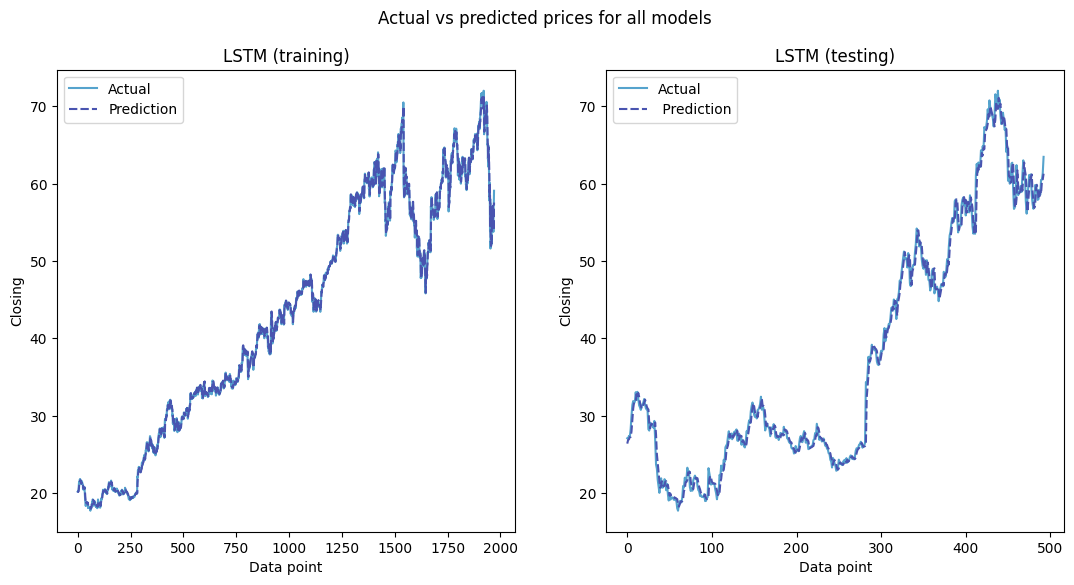

In [173]:
#Prediction vs actual price for LSTM model
sns.set_palette('icefire')

fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
fig.suptitle('Actual vs predicted prices for all models')

lstm_training_plot = sns.lineplot(ax = axes[0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')
lstm_training_plot.set_xlabel('Data point')
lstm_training_plot.set_ylabel('Closing')

lstm_testing_plot = sns.lineplot(ax = axes[1], data = lstm_test_plot)
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point')
lstm_testing_plot.set_ylabel('Closing');


The plot indicates that the LSTM model does a pretty good job of predicting prices. If we compare it to the RNN model, it definitely performs better. If we look carefully back at the RNN plot, it tends to underestimate and overestimate prices during lows and peaks.

**Section 5: Combined plots**

In [174]:
#Additional preparation
mlp1_array_plot = np.append(y_test_predmlp[0:100], y_testmlp[0:100], axis = 1)
mlp1_plot_data = pd.DataFrame(mlp1_array_plot)
mlp1_plot_data.columns = ['Prediction', 'Actual']

mlp2_array_plot = np.append(y_test_predmlp2[0:150], y_test_origmlp2[0:150], axis = 1)
mlp2_plot_data = pd.DataFrame(mlp2_array_plot)
mlp2_plot_data.columns = ['Prediction', 'Actual']

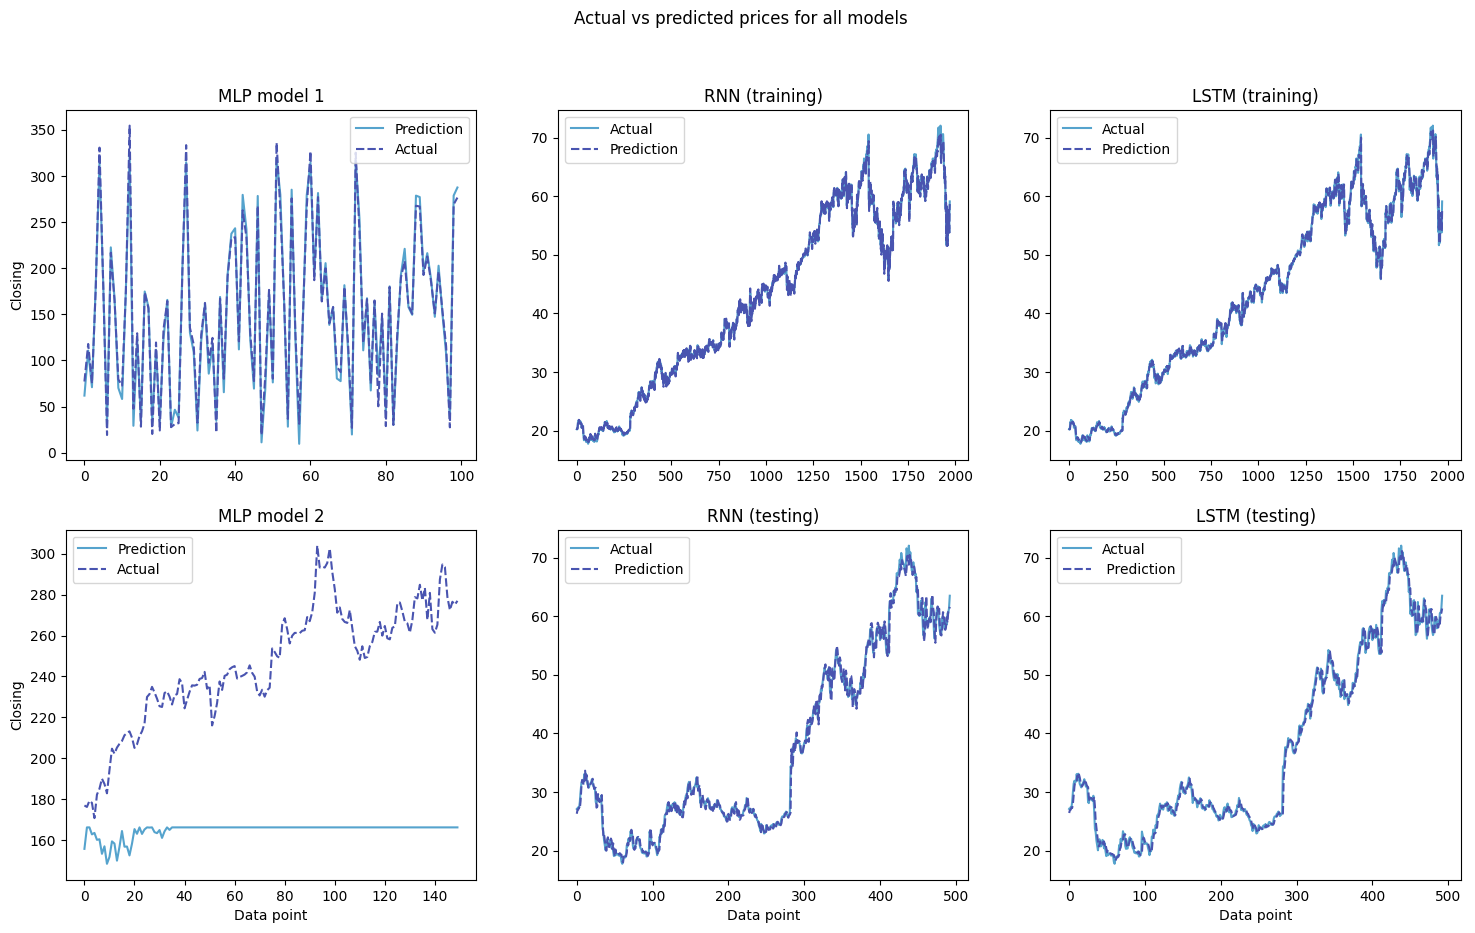

In [175]:
#All plots next to each other
fig, axes = plt.subplots(2, 3, sharex = False, sharey =  False, figsize = (18,10))
fig.suptitle('Actual vs predicted prices for all models')

mlp1_plot = sns.lineplot(ax = axes[0][0], data = mlp1_plot_data)
mlp1_plot.set_title('MLP model 1')
mlp1_plot.set_ylabel('Closing')

mlp2_plot = sns.lineplot(ax = axes[1][0], data = mlp2_plot_data)
mlp2_plot.set_title('MLP model 2')
mlp2_plot.set_xlabel('Data point')
mlp2_plot.set_ylabel('Closing')

rnn_training_plot = sns.lineplot(ax = axes[0][1], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')

rnn_testing_plot = sns.lineplot(ax = axes[1][1], data = rnn_test_plot)
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')

lstm_training_plot = sns.lineplot(ax = axes[0][2], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')

lstm_testing_plot = sns.lineplot(ax = axes[1][2], data = lstm_test_plot)
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point');

In [ ]:
!pip install pandas torch scikit-learn
!pip install dash plotly

In [ ]:
import dash
from dash import Dash  # <-- CORRECTED: Import Dash directly
from dash import dcc
from dash import html
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
import time

# --- 1. Load Data (from user's FB.csv) ---
# Make sure FB.csv is uploaded to your Colab session
try:
    meta = pd.read_csv('FB.csv')
except FileNotFoundError:
    print("ERROR: Please upload FB.csv to your Colab session before running this cell.")
    # Create a dummy app layout to avoid crashing the rest of the cell
    app = Dash(__name__) # <-- Use Dash
    app.layout = html.Div([
        html.H1("Error: FB.csv not found"),
        html.P("Please upload FB.csv to your Colab session and re-run this cell.")
    ])
    # Stop execution if the file isn't found
    raise

meta = meta.dropna(how='any', axis=0)
meta = meta.sort_values('Date')
closing_price_df = meta[['Close']]
dates_df = meta[['Date']]

print("Data loaded. Training models, this may take a moment...")

# --- 2. Define Model Structures (Copied from your notebook) ---

# Model 2 (MLP w/ window) structure
class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_inputs, num_hiddens)
        nn.init.kaiming_uniform_(self.hidden.weight)
        self.activation = nn.ReLU()
        self.out = nn.Linear(num_hiddens, num_outputs)

    def forward(self, X):
        X = self.hidden(X)
        X = self.activation(X)
        X = self.out(X)
        return X

# Model 3 (RNN) structure
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, num_outputs):
        super(RNN, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.rnn = nn.RNN(num_inputs, num_hiddens, num_layers, batch_first=True)
        self.fc = nn.Linear(num_hiddens, num_outputs)

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.num_hiddens).requires_grad_()
        out, h_state = self.rnn(X, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Model 4 (LSTM) structure
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h_0.detach(), c_0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# --- 3. Define Data Preprocessing (Copied from your notebook) ---

# For Model 2 (MLP w/ window)
def split_data_mlp(data, timeframe):
    numpydata = data.to_numpy()
    data_list = []
    for index in range(len(numpydata) - timeframe):
        data_list.append(numpydata[index: index + timeframe])
    data_arr = np.array(data_list)
    test_set_size = int(np.round(0.2*data_arr.shape[0]))
    train_set_size = data_arr.shape[0] - test_set_size

    x_train = data_arr[:train_set_size,:-1,:]
    y_train = data_arr[:train_set_size,-1,:]
    x_test = data_arr[train_set_size:,:-1,:]
    y_test = data_arr[train_set_size:,-1,:]

    x_train = x_train.reshape(train_set_size, timeframe - 1)
    x_test = x_test.reshape(test_set_size, timeframe - 1)

    return [x_train, y_train, x_test, y_test, train_set_size, test_set_size]

# For Models 3 & 4 (RNN/LSTM)
def split_data_rnn(prices, window):
    raw = prices.to_numpy()
    data = []
    for index in range(len(raw) - window):
        data.append(raw[index: index + window])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    X_train = data[:train_set_size,:-1,]
    y_train = data[:train_set_size,-1,:]
    X_test = data[train_set_size:,:-1,]
    y_test = data[train_set_size:,-1,:]

    return [X_train, y_train, X_test, y_test, train_set_size, test_set_size]

# --- 4. Train Models & Get Predictions (Simplified from notebook) ---

# Model 2: MLP w/ Window
timeframe_mlp = 31
scaler_mlp = MinMaxScaler(feature_range=(0, 1))
closing_mlp_scaled = scaler_mlp.fit_transform(closing_price_df['Close'].values.reshape(-1,1))
closing_mlp_scaled_df = pd.DataFrame(closing_mlp_scaled)
x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp, train_size_mlp, test_size_mlp = split_data_mlp(closing_mlp_scaled_df, timeframe_mlp)
x_train_mlp_tensor = torch.from_numpy(x_train_mlp).type(torch.Tensor)
y_train_mlp_tensor = torch.from_numpy(y_train_mlp).type(torch.Tensor)
x_test_mlp_tensor = torch.from_numpy(x_test_mlp).type(torch.Tensor)
mlp_model = MLP(num_inputs=30, num_outputs=1, num_hiddens=4)
loss_fn_mlp = nn.MSELoss()
optimizer_mlp = torch.optim.SGD(mlp_model.parameters(), lr=0.5)

for epoch in range(100):
    y_pred_mlp = mlp_model(x_train_mlp_tensor)
    loss_mlp = loss_fn_mlp(y_pred_mlp, y_train_mlp_tensor)
    optimizer_mlp.zero_grad()
    loss_mlp.backward()
    optimizer_mlp.step()

mlp_model.eval()
y_test_pred_mlp_scaled = mlp_model(x_test_mlp_tensor)
y_test_pred_mlp = scaler_mlp.inverse_transform(y_test_pred_mlp_scaled.detach().numpy())
y_test_actual_mlp = scaler_mlp.inverse_transform(y_test_mlp)

# Models 3 & 4: RNN & LSTM
timeframe_rnn = 15
scaler_rnn_lstm = MinMaxScaler(feature_range=(-1, 1))
X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, train_size_rnn, test_size_rnn = split_data_rnn(closing_price_df, timeframe_rnn)
X_train_rnn_scaled = scaler_rnn_lstm.fit_transform(X_train_rnn.reshape(-1, 1)).reshape(train_size_rnn, timeframe_rnn - 1, 1)
y_train_rnn_scaled = scaler_rnn_lstm.fit_transform(y_train_rnn)
X_test_rnn_scaled = scaler_rnn_lstm.transform(X_test_rnn.reshape(-1, 1)).reshape(test_size_rnn, timeframe_rnn - 1, 1)
y_test_rnn_scaled = scaler_rnn_lstm.transform(y_test_rnn)
X_train_rnn_tensor = torch.from_numpy(X_train_rnn_scaled).type(torch.Tensor)
y_train_rnn_tensor = torch.from_numpy(y_train_rnn_scaled).type(torch.Tensor)
X_test_rnn_tensor = torch.from_numpy(X_test_rnn_scaled).type(torch.Tensor)
y_test_rnn_tensor = torch.from_numpy(y_test_rnn_scaled).type(torch.Tensor)

# Train RNN (Model 3)
rnn_model = RNN(num_inputs=1, num_hiddens=4, num_layers=1, num_outputs=1)
loss_fn_rnn = nn.MSELoss(reduction='mean')
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.1)

for epoch in range(100):
    y_pred_rnn_scaled = rnn_model(X_train_rnn_tensor)
    loss_rnn = loss_fn_rnn(y_pred_rnn_scaled, y_train_rnn_tensor)
    optimizer_rnn.zero_grad()
    loss_rnn.backward()
    optimizer_rnn.step()

rnn_model.eval()
y_test_pred_rnn_scaled = rnn_model(X_test_rnn_tensor)
y_test_pred_rnn = scaler_rnn_lstm.inverse_transform(y_test_pred_rnn_scaled.detach().numpy())
y_test_actual_rnn = scaler_rnn_lstm.inverse_transform(y_test_rnn_scaled)

# Train LSTM (Model 4)
lstm_model = LSTM(input_dim=1, hidden_dim=10, num_layers=1, output_dim=1)
loss_fn_lstm = nn.MSELoss(reduction='mean')
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.1)

for epoch in range(100):
    y_pred_lstm_scaled = lstm_model(X_train_rnn_tensor)
    loss_lstm = loss_fn_lstm(y_pred_lstm_scaled, y_train_rnn_tensor)
    optimizer_lstm.zero_grad()
    loss_lstm.backward()
    optimizer_lstm.step()

lstm_model.eval()
y_test_pred_lstm_scaled = lstm_model(X_test_rnn_tensor)
y_test_pred_lstm = scaler_rnn_lstm.inverse_transform(y_test_pred_lstm_scaled.detach().numpy())

# --- 5. Align Data for Plotting ---
dates_test = dates_df.iloc[train_size_rnn + (timeframe_rnn-1):].values.flatten()
actuals_test = y_test_actual_rnn.flatten()
preds_test_rnn = y_test_pred_rnn.flatten()
preds_test_lstm = y_test_pred_lstm.flatten()
padding = [np.nan] * 3
preds_test_mlp = np.concatenate([padding, y_test_pred_mlp.flatten()])

# --- 6. Calculate Comparison Metrics (RMSE) ---
common_actuals = y_test_actual_rnn[3:]
common_preds_mlp = y_test_pred_mlp
common_preds_rnn = y_test_pred_rnn[3:]
common_preds_lstm = y_test_pred_lstm[3:]

rmse_mlp = sqrt(mean_squared_error(common_actuals, common_preds_mlp))
rmse_rnn = sqrt(mean_squared_error(common_actuals, common_preds_rnn))
rmse_lstm = sqrt(mean_squared_error(common_actuals, common_preds_lstm))

models_list = ['MLP (Window)', 'RNN', 'LSTM']
rmse_values = [rmse_mlp, rmse_rnn, rmse_lstm]
print("Models trained and data processed. Building dashboard...")

# --- 7. Create Plotly Figures ---
fig_predictions = go.Figure()
fig_predictions.add_trace(go.Scatter(x=dates_test, y=actuals_test, mode='lines', name='Actual Price', line=dict(color='black', width=2)))
fig_predictions.add_trace(go.Scatter(x=dates_test, y=preds_test_mlp, mode='lines', name='MLP (Window) Pred.'))
fig_predictions.add_trace(go.Scatter(x=dates_test, y=preds_test_rnn, mode='lines', name='RNN Pred.'))
fig_predictions.add_trace(go.Scatter(x=dates_test, y=preds_test_lstm, mode='lines', name='LSTM Pred.'))
fig_predictions.update_layout(title='Model Predictions vs. Actual Stock Price (Test Set)',
                              xaxis_title='Date',
                              yaxis_title='Stock Price (USD)',
                              legend_title='Model')

fig_comparison = go.Figure([
    go.Bar(x=models_list, y=rmse_values, marker_color=['blue', 'green', 'red'])
])
fig_comparison.update_layout(title='Model Comparison (Test Set RMSE)',
                             xaxis_title='Model',
                             yaxis_title='Root Mean Squared Error (USD)')

# --- 8. Build and Run the Dash App ---
app = Dash(__name__)  # <-- CORRECTED: Use Dash

app.layout = html.Div(style={'backgroundColor': '#f0f0f0', 'padding': '20px'}, children=[
    html.H1("Stock Price Model Comparison", style={'textAlign': 'center', 'color': '#333'}),

    html.Div(style={'backgroundColor': 'white', 'padding': '20px', 'borderRadius': '5px', 'marginBottom': '20px'}, children=[
        html.H3("Prediction Graph", style={'color': '#555'}),
        html.P("Comparing the actual test prices against the predictions from the three models."),
        dcc.Graph(id='predictions-graph', figure=fig_predictions)
    ]),

    html.Div(style={'backgroundColor': 'white', 'padding': '20px', 'borderRadius': '5px'}, children=[
        html.H3("Model Comparison Graph (RMSE)", style={'color': '#555'}),
        html.P("Lower RMSE (Root Mean Squared Error) is better."),
        dcc.Graph(id='comparison-graph', figure=fig_comparison)
    ])
])

# Run the app inline in your Colab notebook
if __name__ == '__main__':
    app.run(jupyter_mode="inline") # <-- CORRECTED: Use this method to run in Colab/Jupyter